# Bayesian Optimisation NN

### The purpose of the kernel is to demonstrate how to find an optimal set of hyper-parameters for various NN models

### UPDATE:

- v.1,2: Model architecture: 2048-X-X-X -->  hyperparams: dense_units, dropouts, activations
-   v.3: Model architecture: 2048-1024-X-X ->> hyperparams: dense_units, dropouts, activations
- v.4-5: Model architecture: 2048-1024-512-X ->> hyperparams: dense_units, dropouts, activations, look_ahead + (fix compatibility issues)

# Imports

### NOTE: make sure you downgrade sklearn --> install it from the .whl (due to compatibility issues)

In [1]:
!pip install ../input/my-wheels/scikit_learn-0.21.0-cp37-cp37m-manylinux1_x86_64.whl

# !pip install -U scikit-learn==0.21.0
# !pip install scikit-optimize==0.8.dev0

Processing /kaggle/input/my-wheels/scikit_learn-0.21.0-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tpot 0.11.5 requires scikit-learn>=0.22.0, but you'll have scikit-learn 0.21.0 which is incompatible.
sklearn-pandas 2.0.0 requires scikit-learn>=0.23.0, but you'll have scikit-learn 0.21.0 which is incompatible.
kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
kmeans-smote 0.1.2 requires numpy<1.16,>=1.13, but you'll have numpy 1.18.5 which is incompatible.
kmeans

In [2]:
# import sys
# sys.path.append('../input/iterative-stratification/iterative-stratification-master')
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
import os
import gc
import random
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import *
from skopt.utils import use_named_args

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa
from tqdm.notebook import tqdm

import sklearn
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss
import category_encoders as ce

print(os.listdir('../input/lish-moa'))

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


['test_features.csv', 'sample_submission.csv', 'train_features.csv', 'train_targets_scored.csv', 'train_targets_nonscored.csv']


In [4]:
skopt.__version__, sklearn.__version__

('0.8.1', '0.21.0')

# Helpers

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(seed=42)

In [6]:
def preprocess(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df


In [7]:
# permuation importance by: https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2

# hardoced features
top_feats = [  0,   1,   2,   3,   5,   6,   8,   9,  10,  11,  12,  14,  15,
        16,  18,  19,  20,  21,  23,  24,  25,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  44,  45,  46,
        48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        63,  64,  65,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  90,  92,
        93,  94,  95,  96,  97,  99, 100, 101, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 163, 164,
       165, 166, 167, 168, 169, 170, 172, 173, 175, 176, 177, 178, 180,
       181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 195,
       197, 198, 199, 202, 203, 205, 206, 208, 209, 210, 211, 212, 213,
       214, 215, 218, 219, 220, 221, 222, 224, 225, 227, 228, 229, 230,
       231, 232, 233, 234, 236, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 248, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 263, 265, 266, 268, 270, 271, 272, 273, 275, 276, 277, 279,
       282, 283, 286, 287, 288, 289, 290, 294, 295, 296, 297, 299, 300,
       301, 302, 303, 304, 305, 306, 308, 309, 310, 311, 312, 313, 315,
       316, 317, 320, 321, 322, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 338, 339, 340, 341, 343, 344, 345, 346, 347,
       349, 350, 351, 352, 353, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 368, 369, 370, 371, 372, 374, 375, 376, 377,
       378, 379, 380, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
       392, 393, 394, 395, 397, 398, 399, 400, 401, 403, 405, 406, 407,
       408, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
       436, 437, 438, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       452, 453, 454, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 468, 469, 471, 472, 473, 474, 475, 476, 477, 478, 479, 482,
       483, 485, 486, 487, 488, 489, 491, 492, 494, 495, 496, 500, 501,
       502, 503, 505, 506, 507, 509, 510, 511, 512, 513, 514, 516, 517,
       518, 519, 521, 523, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547,
       549, 550, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
       564, 565, 566, 567, 569, 570, 571, 572, 573, 574, 575, 577, 580,
       581, 582, 583, 586, 587, 590, 591, 592, 593, 595, 596, 597, 598,
       599, 600, 601, 602, 603, 605, 607, 608, 609, 611, 612, 613, 614,
       615, 616, 617, 619, 622, 623, 625, 627, 630, 631, 632, 633, 634,
       635, 637, 638, 639, 642, 643, 644, 645, 646, 647, 649, 650, 651,
       652, 654, 655, 658, 659, 660, 661, 662, 663, 664, 666, 667, 668,
       669, 670, 672, 674, 675, 676, 677, 678, 680, 681, 682, 684, 685,
       686, 687, 688, 689, 691, 692, 694, 695, 696, 697, 699, 700, 701,
       702, 703, 704, 705, 707, 708, 709, 711, 712, 713, 714, 715, 716,
       717, 723, 725, 727, 728, 729, 730, 731, 732, 734, 736, 737, 738,
       739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751,
       752, 753, 754, 755, 756, 758, 759, 760, 761, 762, 763, 764, 765,
       766, 767, 769, 770, 771, 772, 774, 775, 780, 781, 782, 783, 784,
       785, 787, 788, 790, 793, 795, 797, 799, 800, 801, 805, 808, 809,
       811, 812, 813, 816, 819, 820, 821, 822, 823, 825, 826, 827, 829,
       831, 832, 833, 834, 835, 837, 838, 839, 840, 841, 842, 844, 845,
       846, 847, 848, 850, 851, 852, 854, 855, 856, 858, 860, 861, 862,
       864, 867, 868, 870, 871, 873, 874]

print(len(top_feats))

696


# Config

In [8]:
PERM_IMP = True
OHE = False

N_TRIALS = 15
SEED = 34 # 2020

# Load data

In [9]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

subm = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [10]:
cat_features = ['cp_type', 'cp_time', 'cp_dose']
num_features = [c for c in train_features.columns if train_features.dtypes[c] != 'object']
num_features = [c for c in num_features if c not in cat_features]

target_cols = [c for c in train_targets.columns if c not in ['sig_id']]
targets = train_targets[target_cols]

train_x = preprocess(train_features)
test_x = preprocess(test_features)
print('Tensor shapes:', train_x.shape, targets.shape, test_x.shape)

if PERM_IMP: 
    train_x = train_x.iloc[:, top_feats]
    test_x = test_x.iloc[:, top_feats]

# ohe cols
if OHE:
    train_x = pd.get_dummies(train_x, columns=train_x[cat_features].columns)
    test_x = pd.get_dummies(test_x, columns=test_x[cat_features].columns)

print('Final tensor shapes:', train_x.shape, targets.shape, test_x.shape)

Tensor shapes: (23814, 875) (23814, 206) (3982, 875)
Final tensor shapes: (23814, 696) (23814, 206) (3982, 696)


In [11]:
train_x.head()

,cp_type,cp_time,cp_dose,g-0,g-2,g-3,g-5,g-6,g-7,g-8,...,c-85,c-86,c-87,c-89,c-92,c-93,c-95,c-96,c-98,c-99
0,0,0,0,1.0620,-0.2479,-0.6208,-1.0120,-1.0220,-0.0326,0.5548,...,0.1799,0.5367,-0.1111,0.6685,0.8076,0.5523,0.6584,-0.3981,0.3801,0.4176
1,0,2,0,0.0743,0.2991,0.0604,0.5207,0.2341,0.3372,-0.4047,...,0.4420,0.9366,0.8193,0.3192,0.4708,0.0230,0.4899,0.1522,0.6077,0.7371
2,0,1,0,0.6280,1.5540,-0.0764,1.2390,0.1715,0.2155,0.0065,...,0.1172,0.1093,-0.3113,-0.0873,0.6103,0.0223,-0.3174,-0.6417,-1.4080,0.6931
3,0,1,0,-0.5138,-0.2656,0.5288,-0.8095,-1.9590,0.1792,-0.1321,...,-1.5390,-2.4600,-0.9417,0.2431,-5.6300,-1.3780,-1.2880,-1.6210,-0.3876,-0.8154
4,0,2,1,-0.3254,0.9700,0.6919,-0.8244,-0.2800,-0.1498,-0.8789,...,0.0698,0.8134,0.1924,-0.1824,0.6670,1.0690,-0.3031,0.1094,-0.3786,0.7125


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_x, targets, test_size=0.2)
    
x_train.shape, x_val.shape

((19051, 696), (4763, 696))

# Use Bayesian Optimization for Hyper-parameter search
The idea with Bayesian optimization is to construct another model of the search-space for hyper-parameters. One kind of model is known as a Gaussian Process. This gives us an estimate of how the performance varies with changes to the hyper-parameters. Whenever we evaluate the actual performance for a set of hyper-parameters, we know for a fact what the performance is - except perhaps for some noise. We can then ask the Bayesian optimizer to give us a new suggestion for hyper-parameters in a region of the search-space that we haven't explored yet, or hyper-parameters that the Bayesian optimizer thinks will bring us most improvement. We then repeat this process a number of times until the Bayesian optimizer has built a good model of how the performance varies with different hyper-parameters, so we can choose the best parameters.

The flowchart of the algorithm is roughly:

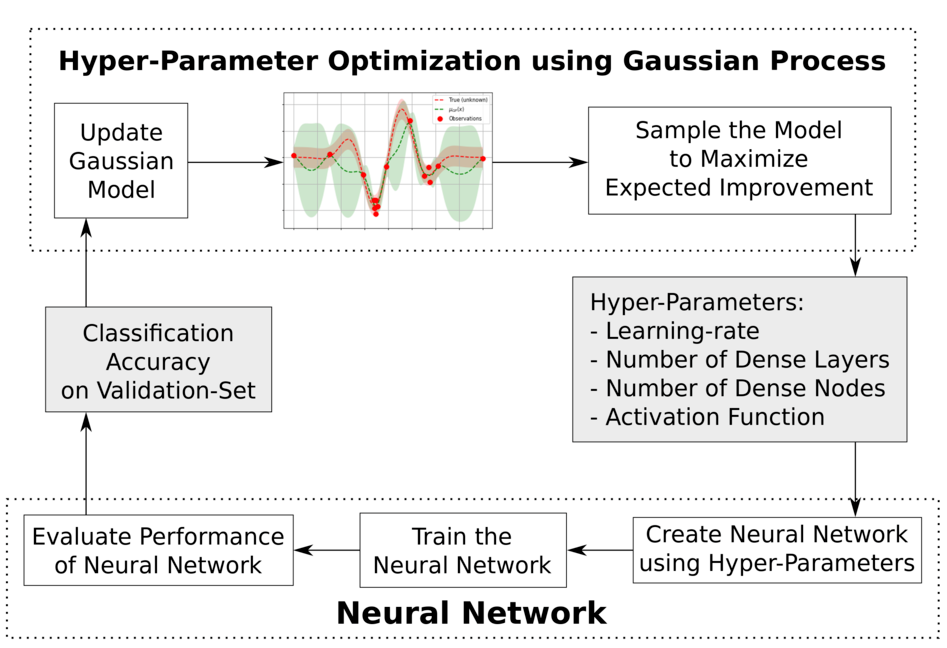

### NN architrecture & hyper-parameters

V.3-4 NN architecture: 2048-1024-512-X   

- dense nodes (layer 4)
- activations
- dropout x 4  
- looak ahead steps (for optimizer)

In [13]:
# dim_num_dense_layers = Integer(low=2, high=10, name='num_dense_layers')

# dim_learning_rate = Real(low=1e-4, high=1e-1, prior='uniform', name='learning_rate')
# dim_num_dense_nodes_1 = Integer(low=1024, high=2048, name='num_dense_nodes_1')
# dim_num_dense_nodes_2 = Integer(low=512, high=1024, name='num_dense_nodes_2')
dim_num_dense_nodes_3 = Integer(low=256, high=512, name='num_dense_nodes_3')
dim_activation = Categorical(categories=['relu', 'elu'], name='activation')
dim_dropout1 = Integer(low=1, high=5, name='dp1')
dim_dropout2 = Integer(low=1, high=5, name='dp2')
dim_dropout3 = Integer(low=1, high=5, name='dp3')
dim_dropout4 = Integer(low=1, high=5, name='dp4')
dim_look_ahead = Integer(low=5, high=15, name='look_ahead')


dimensions = [
#     dim_learning_rate,
#     dim_num_dense_nodes_1,
#     dim_num_dense_nodes_2,
    dim_num_dense_nodes_3,
    dim_activation,
    dim_dropout1,
    dim_dropout2,
    dim_dropout3,
    dim_dropout4,
    dim_look_ahead
]


# set default params - make sure are within the search space
default_params = [512, 'relu', 5, 5, 5, 5, 6] # v.3-4

assert len(default_params)==len(dimensions), 'Error: check shapes!'

## Create Model

In [14]:
n_inputs = len(top_feats)
n_outs = len(target_cols)

def create_model(
#     learning_rate, 
#     num_dense_nodes_1, 
#     num_dense_nodes_2,
    num_dense_nodes_3,
    activation, 
    dp1,
    dp2,
    dp3,
    dp4,
    look_ahead
):
    
    weight_norm = False
    
    inp = tf.keras.layers.Input(n_inputs)
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(2048, activation=activation)(x)
    if weight_norm:
        x = tfa.layers.WeightNormalization(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1*dp1)(x)
    
    x = tf.keras.layers.Dense(1024, activation=activation)(x)
    if weight_norm:
        x = tfa.layers.WeightNormalization(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1*dp2)(x)
    
    x = tf.keras.layers.Dense(512, activation=activation)(x)
    if weight_norm:
        x = tfa.layers.WeightNormalization(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1*dp3)(x)
    
    x = tf.keras.layers.Dense(num_dense_nodes_3, activation=activation)(x)
    if weight_norm:
        x = tfa.layers.WeightNormalization(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1*dp4)(x)
    
    out = tf.keras.layers.Dense(n_outs, activation="sigmoid")(x)                            
    model = tf.keras.models.Model(inp, out)
    
    # optimizers
    opt = tf.keras.optimizers.Adam(lr=1e-3)   # learning_rate
    #     opt = tfa.optimizers.SWA(opt, 100)
    #     opt = tfa.optimizers.AdamW(weight_decay=0.01)
    opt = tfa.optimizers.Lookahead(opt, sync_period=int(look_ahead))
    
    # compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])

    return model

# Fittness Function to Optimize


This is the function that creates and trains a neural network with the given hyper-parameters, and then evaluates its performance on the validation-set. The function then returns the so-called fitness value (aka. objective value), which is the negative classification accuracy on the validation-set. It is negative because skopt performs minimization instead of maximization.

The main steps that we perform are:

- build and train a network with given hyper-parameters
- evaluate the model performance with the validation dataset
- It returns the fitness value, in our case the logloss error.




Note the function decorator `@use_named_args` which wraps the fitness function so that it can be called with all the parameters as a single list, for example: `fitness(x=[1e-4, 3, 256, 'relu'])`. This is the calling-style skopt uses internally.

In [15]:
path_best_model = './model.h5'
best_loss = np.inf

In [16]:
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes_3, activation, dp1, dp2, dp3, dp4, look_ahead):   
    
    """
    Hyper-parameters:
    num_dense_nodes:   Number of nodes in layer 4.
    activation:        Activation function for all layers.
    dp:                Dropout rates (x4)
    look_ahead:        Look ahead steps (Adam optimizer)
    """

    # Print the hyper-parameters.
    #     print('learning rate: {0:.1e}'.format(learning_rate))
    #     print('num_dense_nodes 1:', num_dense_nodes_1)
    #     print('num_dense_nodes 2:', num_dense_nodes_2)
    print('num_dense_nodes layer-4:', num_dense_nodes_3)
    print('activation:',activation)
    print('dropout 1:', dp1*0.1)
    print('dropout 2:', dp2*0.1)
    print('dropout 3:', dp3*0.1)
    print('dropout 4:', dp4*0.1)
    print('look ahead:',look_ahead)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(
        num_dense_nodes_3,
        activation, 
        dp1,
        dp2,
        dp3,
        dp4,
        look_ahead)

    
    # Create callback-functions
    cbs = [
        tf.keras.callbacks.EarlyStopping('val_loss', patience=30, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.1) ]

   
    # train the model
    hist = model.fit(x = x_train,
                     y = y_train,
                     epochs=65,
                     batch_size=128,
                     validation_data=(x_val, y_val),
                     callbacks=cbs,
                     verbose = 0 )

    # Get the error on the validation-set
    log_loss = min(hist.history['val_loss'])   

    # Print the classification accuracy.
    print('-'*20)
    print(f"> Log loss: {log_loss}")
    print('-'*20)

    # Save the model if it improves on the best-found performance.
    global best_loss

    # If the classification accuracy of the saved model is improved ...
    if log_loss < best_loss:
        
        # Save the new model & Update the error
        model.save(path_best_model)
        best_loss = log_loss

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    gc.collect()
    
    # Clear the Keras session, to empty the TensorFlow graph 
    K.clear_session()
    
    return log_loss

In [17]:
# check objective function (uncomment bellow if you like to test)

# fitness(default_params)

# Run Bayesian Optimization

We may control the runtime of the optimization process by `N_TRIALS`: selecting the no. of evaluation runs

In [18]:
search_result = skopt.gp_minimize(func=fitness,   
                            dimensions=dimensions,
                            acq_func='EI',    #  'gp_hedge'       
                            n_calls=N_TRIALS,
                            random_state=SEED,
                            x0=default_params)

num_dense_nodes layer-4: 512
activation: relu
dropout 1: 0.5
dropout 2: 0.5
dropout 3: 0.5
dropout 4: 0.5
look ahead: 6

--------------------
> Log loss: 0.0157941784709692
--------------------
num_dense_nodes layer-4: 306
activation: elu
dropout 1: 0.30000000000000004
dropout 2: 0.30000000000000004
dropout 3: 0.1
dropout 4: 0.4
look ahead: 8

--------------------
> Log loss: 0.015828106552362442
--------------------
num_dense_nodes layer-4: 361
activation: relu
dropout 1: 0.4
dropout 2: 0.4
dropout 3: 0.4
dropout 4: 0.5
look ahead: 9

--------------------
> Log loss: 0.015850508585572243
--------------------
num_dense_nodes layer-4: 356
activation: relu
dropout 1: 0.4
dropout 2: 0.30000000000000004
dropout 3: 0.30000000000000004
dropout 4: 0.30000000000000004
look ahead: 8

--------------------
> Log loss: 0.01570500247180462
--------------------
num_dense_nodes layer-4: 477
activation: elu
dropout 1: 0.30000000000000004
dropout 2: 0.30000000000000004
dropout 3: 0.5
dropout 4: 0.4
loo

# Results

In [19]:
print('optimal hyper-parameters') 
print()
# print(f'lr: {search_result.x[0]}')
# print(f'dense_units 1: {search_result.x[1]}')
# print(f'dense_units 2: {search_result.x[2]}')
print(f'dense_units 3: {search_result.x[0]}')
print(f'activation: {search_result.x[1]}')
print(f'dropout 1: {search_result.x[2]}')
print(f'dropout 2: {search_result.x[3]}')
print(f'dropout 3: {search_result.x[4]}')
print(f'dropout 4: {search_result.x[5]}')
print(f'Look ahead: {search_result.x[6]}')


# ----------------------------
# optimal hyper-parameters v.3
# ----------------------------
# dense_units 3: 511
# activation: elu
# dropout 1: 3
# dropout 2: 4
# dropout 3: 5
# dropout 4: 2

optimal hyper-parameters

dense_units 3: 395
activation: elu
dropout 1: 4
dropout 2: 5
dropout 3: 5
dropout 4: 2
Look ahead: 14


In [20]:
pd.DataFrame(sorted(zip(search_result.func_vals, search_result.x_iters)), index=np.arange(N_TRIALS), columns=['score', 'params'])

,score,params
0,0.015371,"[395, elu, 4, 5, 5, 2, 14]"
1,0.015404,"[473, elu, 3, 1, 5, 1, 11]"
2,0.015431,"[266, elu, 5, 1, 4, 1, 6]"
3,0.015471,"[495, elu, 1, 1, 4, 5, 15]"
4,0.015618,"[477, elu, 3, 3, 5, 4, 5]"
5,0.015705,"[356, relu, 4, 3, 3, 3, 8]"
6,0.015752,"[392, elu, 4, 5, 2, 3, 12]"
7,0.015794,"[512, relu, 5, 5, 5, 5, 6]"
8,0.015822,"[396, relu, 2, 2, 2, 2, 11]"
9,0.015828,"[306, elu, 3, 3, 1, 4, 8]"


### Let's visualize the progress of the whole optimization session, where the fitness values are shown on y-axis.

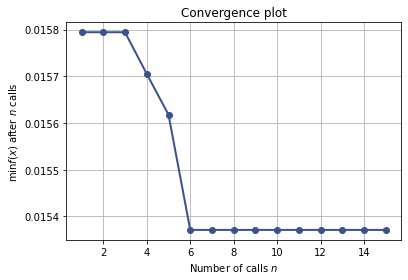

In [21]:
%matplotlib inline
plot_convergence(search_result)

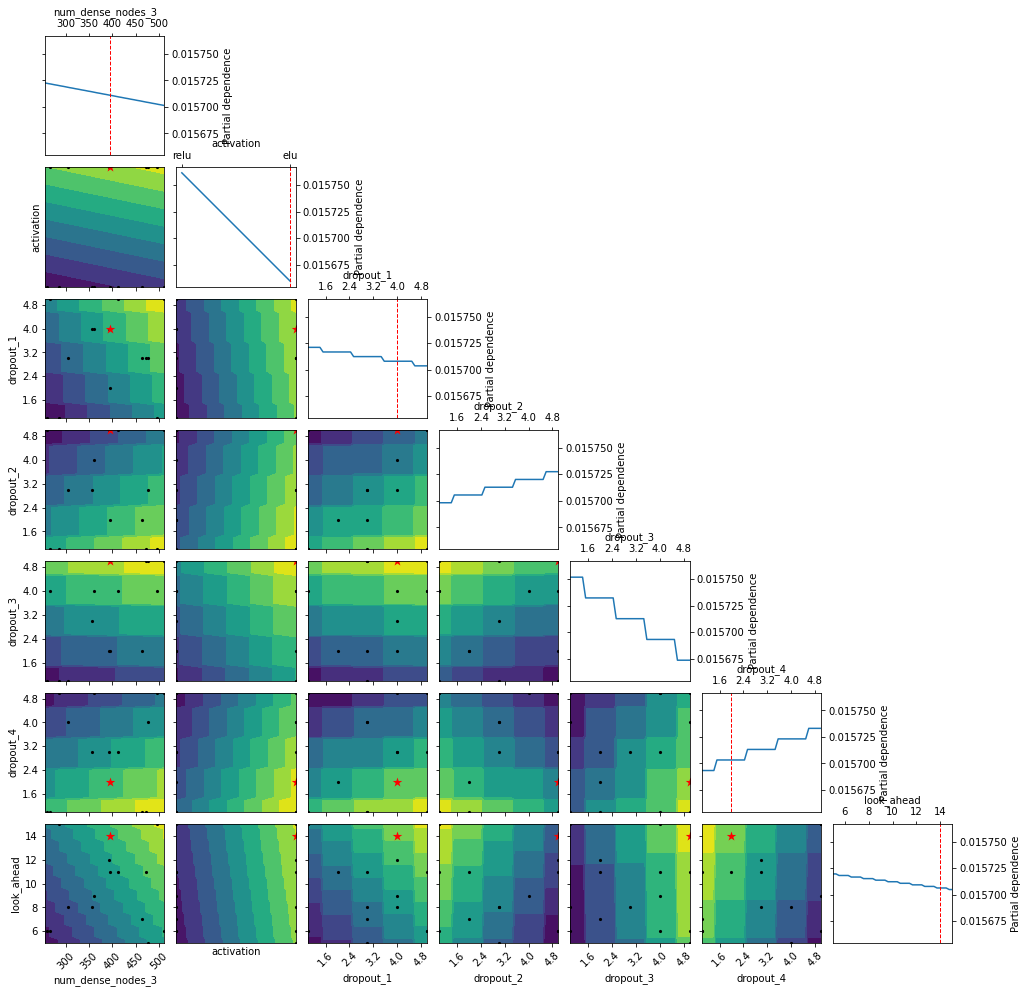

In [22]:
# create a list for plotting
dim_names = ['num_dense_nodes_3', 'activation', 'dropout_1', 'dropout_2', 'dropout_3', 'dropout_4', 'look_ahead']

# %matplotlib inline
plot_objective(result=search_result, dimensions=dim_names);

# Reproduce Model with best hyperparams

In [23]:
# create model with best hyperparams

model = create_model(*search_result.x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 696)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 696)               2784      
_________________________________________________________________
dropout (Dropout)            (None, 696)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              1427456   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)             

In [24]:
FOLDS = 5

oof = targets.copy()
subm.loc[:, target_cols] = 0
oof.loc[:, target_cols] = 0

splits = KFold(n_splits=FOLDS, random_state=SEED, shuffle=True).split(train_x)

for n, (tr, te) in enumerate(splits):
    
    print(f'Fold {n}')    

    checkpoint_path = f'./model_Fold_{n}.h5'
    cbs = [
        tf.keras.callbacks.EarlyStopping('val_loss', patience=30, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, restore_best_weights=True, verbose=1,  save_weights_only=True, mode='min'),
        # step_decay_schedule(initial_lr=LR, decay_factor=0.1, step_size=5)
        tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.1, verbose=1, min_delta=1e-4, mode='min'),
        #   get_lr_schedule(BATCH_SIZE)
        # CyclicLR(base_lr=0.0001, max_lr=0.06, step_size=5000., mode='exp_range', verbose=1)  # 
        # WarmUpCosineDecayScheduler(learning_rate_base=LR)
        ]

    model = create_model(*search_result.x)

    model.fit(train_x.values[tr], targets.values[tr],
              validation_data=(train_x.values[te], targets.values[te]),
              epochs=80, 
              batch_size=128, 
              callbacks=cbs, 
              verbose=1)

    model.load_weights(checkpoint_path)

    subm.loc[:, target_cols] += model.predict(test_x.values)
    oof.loc[te, target_cols] += model.predict(train_x.values[te])
    print('-'*20)

subm.loc[:, target_cols] /= FOLDS

Fold 0
Epoch 1/80
147/149 [============================>.] - ETA: 0s - loss: 0.5791 - auc: 0.5555
Epoch 00001: val_loss improved from inf to 0.21786, saving model to ./model_Fold_0.h5
149/149 [==============================] - 3s 19ms/step - loss: 0.5750 - auc: 0.5550 - val_loss: 0.2179 - val_auc: 0.6153
Epoch 2/80
148/149 [============================>.] - ETA: 0s - loss: 0.1077 - auc: 0.5776
Epoch 00002: val_loss improved from 0.21786 to 0.04531, saving model to ./model_Fold_0.h5
149/149 [==============================] - 2s 15ms/step - loss: 0.1074 - auc: 0.5775 - val_loss: 0.0453 - val_auc: 0.6902
Epoch 3/80
147/149 [============================>.] - ETA: 0s - loss: 0.0347 - auc: 0.6291
Epoch 00003: val_loss improved from 0.04531 to 0.02584, saving model to ./model_Fold_0.h5
149/149 [==============================] - 2s 15ms/step - loss: 0.0346 - auc: 0.6302 - val_loss: 0.0258 - val_auc: 0.7281
Epoch 4/80
148/149 [============================>.] - ETA: 0s - loss: 0.0250 - auc: 0.68

In [25]:
metrics = []
for _target in target_cols:
    metrics.append(log_loss(targets.loc[:, _target], oof.loc[:, _target]))
    
print(f'OOF Metric: {np.mean(metrics).round(8)}')

OOF Metric: 0.01502405


In [26]:
# with post-process
oof.loc[train_x['cp_type']==1, target_cols] = 0

metrics = []
for _target in target_cols:
    metrics.append(log_loss(targets.loc[:, _target], oof.loc[:, _target]))

print(f'OOF Metric (with post-processing): {np.mean(metrics).round(8)}')

OOF Metric (with post-processing): 0.01500424


In [27]:
# # train the model with best hyperparams - all data

# hist = model.fit(train_x, targets,
#                  epochs=100,
#                  batch_size=128,
#                  validation_split=0.2,  # validation_data=(x_val, y_val),
#                  callbacks=cbs)

# predictions = model.predict(test_x.values)
# subm.loc[:,target_cols] = predictions

# Submission!

In [28]:
subm.loc[test_x['cp_type']==1, target_cols] = 0
subm.to_csv('submission.csv', index=False)

In [29]:
subm.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000534,0.000758,0.001152,0.016790,0.019869,0.006096,0.001244,0.006220,0.000043,...,0.000430,0.001083,0.002999,0.001797,0.000255,0.000324,0.000221,0.001104,0.013819,0.001228
1,id_001897cda,0.000156,0.000609,0.001387,0.001585,0.001651,0.001478,0.002079,0.009012,0.008065,...,0.000261,0.000776,0.001341,0.000094,0.007780,0.000270,0.005022,0.000819,0.002539,0.001562
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000616,0.000478,0.001310,0.017366,0.014481,0.004584,0.002322,0.004176,0.000173,...,0.000228,0.000873,0.002829,0.015854,0.005471,0.000326,0.000699,0.002354,0.001765,0.003252
4,id_0027f1083,0.001212,0.000960,0.001334,0.018205,0.022553,0.004641,0.007020,0.001566,0.000118,...,0.000291,0.000584,0.008141,0.002185,0.000444,0.000343,0.000643,0.001696,0.000408,0.001133


# Work in progress!

- Search more hyperparams eg. layers, optimizers, etc 

## Credits

- [towards-data-science article](https://towardsdatascience.com/bayesian-hyper-parameter-optimization-neural-networks-tensorflow-facies-prediction-example-f9c48d21f795)

- [skopt documentation and examples](https://scikit-optimize.github.io/stable/user_guide.html)



## Reference notebooks

- https://www.kaggle.com/stanleyjzheng/baseline-nn-with-k-folds 
- https://www.kaggle.com/simakov/multilabel-neural-network
- https://www.kaggle.com/ravy101/drug-moa-tf-keras-starter